<a href="https://colab.research.google.com/github/rafihorse/bioinformatics_portfolio/blob/main/AncestryDesert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# !pip install pingouin
# !pip install scipy --no-cache-dir
# !pip install xlrd
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import numba as nb
import time
import bisect
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from zipfile import ZipFile
from glob import glob

In [ ]:
# from google.colab import output
# output.enable_custom_widget_manager()

# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# mount google drive to retrieve files
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/Reich Lab'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Reich Lab


## Testing deserts only from ancestry BED file

In [ ]:
thefile = "chr-7.thresh-90.length-0.00.gz"
snp_table = pd.read_table(thefile, header=None, usecols=[0,10,14,16], names=["snp_id", "p_nean", "num_nean_alleles", "num_mh_alleles"], skiprows=27)
snp_table["chr"] = snp_table["snp_id"].str[0:1]
snp_table["snp_id"] = snp_table["snp_id"].str[2:].astype(int)
print(snp_table)

            snp_id  p_nean  num_nean_alleles  num_mh_alleles chr
0           152666   0.027               0.0           0.965   7
1           152693   0.027               0.0           0.965   7
2           152695   0.027               0.0           0.965   7
3           152852   0.027               0.0           0.965   7
4           152869   0.027               0.0           0.965   7
...            ...     ...               ...             ...  ..
1880325  159027267   0.024               0.0           1.000   7
1880326  159027390   0.024               0.0           1.000   7
1880327  159027486   0.024               0.0           1.000   7
1880328  159027523   0.024               0.0           1.000   7
1880329  159027758   0.024               0.0           1.000   7

[1880330 rows x 5 columns]


In [ ]:
chr_length = 159345973
win_size = 10000000

for w in range(0, chr_length, win_size):
  nean_anc = snp_table.loc[(snp_table["p_nean"] > 0.9) & (snp_table["snp_id"].between(w, w + win_size))]
  nean_count = len(nean_anc)
  snp_count = len(snp_table.loc[(snp_table["snp_id"].between(w, w + win_size))])
  window = "{0} - {1}".format(w, w + win_size)
  nean_perc = nean_count / snp_count
  print("Window: {0} \nNeanderthal SNPs: {1} \nTotal SNPs: {2} \nPercent Neanderthal: {3}\n".format(window, nean_count, snp_count, nean_perc))

Window: 0 - 10000000 
Neanderthal SNPs: 0 
Total SNPs: 144106 
Percent Neanderthal: 0.0

Window: 10000000 - 20000000 
Neanderthal SNPs: 0 
Total SNPs: 156502 
Percent Neanderthal: 0.0

Window: 20000000 - 30000000 
Neanderthal SNPs: 0 
Total SNPs: 131495 
Percent Neanderthal: 0.0

Window: 30000000 - 40000000 
Neanderthal SNPs: 0 
Total SNPs: 123721 
Percent Neanderthal: 0.0

Window: 40000000 - 50000000 
Neanderthal SNPs: 0 
Total SNPs: 125487 
Percent Neanderthal: 0.0

Window: 50000000 - 60000000 
Neanderthal SNPs: 0 
Total SNPs: 93350 
Percent Neanderthal: 0.0

Window: 60000000 - 70000000 
Neanderthal SNPs: 0 
Total SNPs: 62271 
Percent Neanderthal: 0.0

Window: 70000000 - 80000000 
Neanderthal SNPs: 0 
Total SNPs: 98221 
Percent Neanderthal: 0.0

Window: 80000000 - 90000000 
Neanderthal SNPs: 0 
Total SNPs: 124695 
Percent Neanderthal: 0.0

Window: 90000000 - 100000000 
Neanderthal SNPs: 0 
Total SNPs: 111451 
Percent Neanderthal: 0.0

Window: 100000000 - 110000000 
Neanderthal SNPs: 

<Axes: xlabel='snp_id'>

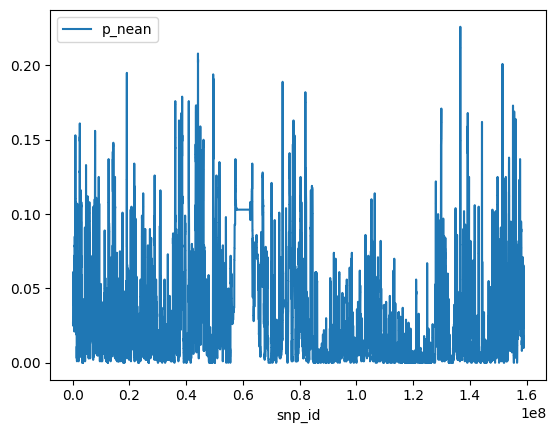

In [ ]:
snp_table.plot("snp_id", "p_nean")

In [ ]:
thefile = "contigs.all"
nean_tile = pd.read_table(thefile, header=None, usecols=[0,1,2], names=["chr", "start", "stop"], dtype=int)
print(nean_tile)

chr7 = nean_tile.loc[nean_tile["chr"]==7]
chr7["color"] = "green"
print(chr7)

      chr     start      stop
0       1   1980170   2062368
1       1   2221273   2243773
2       1   2392700   2753379
3       1   2785882   3110384
4       1   3123757   3456893
...   ...       ...       ...
4432   22  49803108  49825188
4433   22  49850844  49911273
4434   22  49928134  50923386
4435   22  50937043  51051214
4436   22  51052411  51141161

[4437 rows x 3 columns]
      chr      start       stop  color
1883    7     157193     526808  green
1884    7     529292     661192  green
1885    7     667695     964780  green
1886    7     992845    1218730  green
1887    7    1602935    1629188  green
...   ...        ...        ...    ...
2107    7  156818426  157602637  green
2108    7  157661055  157730293  green
2109    7  157789327  157869392  green
2110    7  157888204  158750306  green
2111    7  158858033  158950641  green

[229 rows x 4 columns]


/tmp/ipython-input-1831061525.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr7["color"] = "green"


(-10000000.0, 169345973.0)

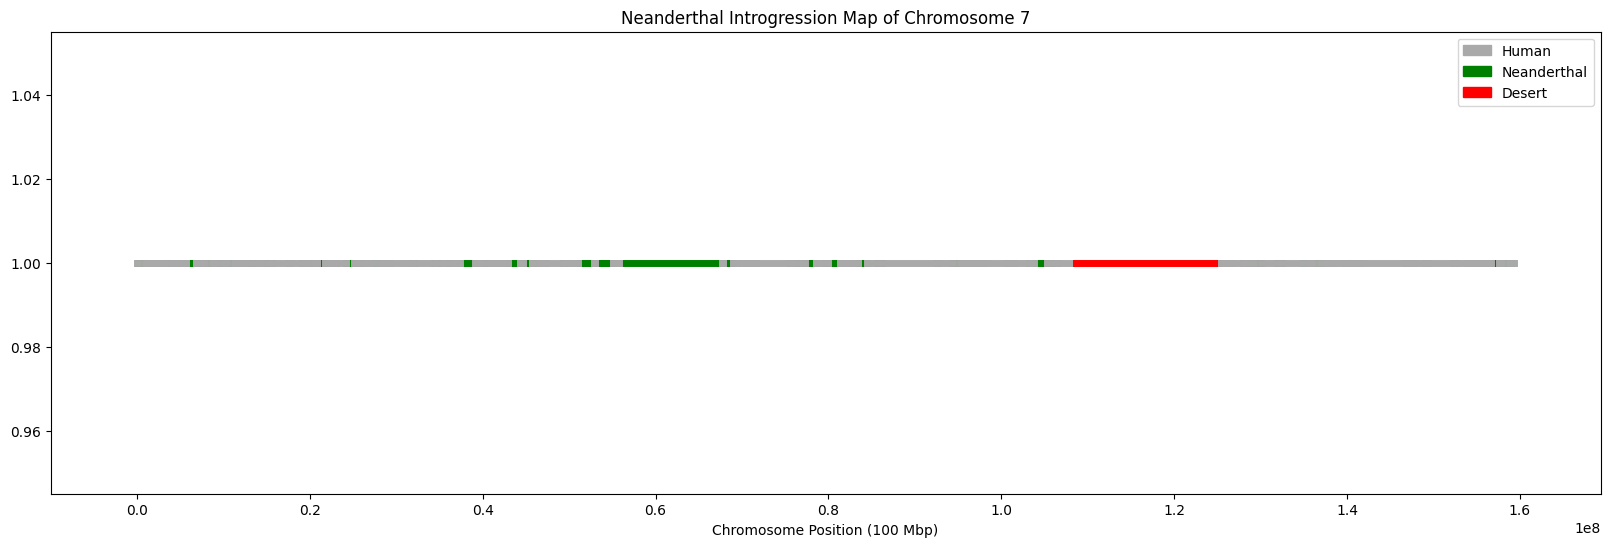

In [ ]:
chr_length = 159345973

start_space = 0

chr7_deserts = pd.DataFrame({
    "chr": pd.Series(dtype='int'),
    "start": pd.Series(dtype='int'),
    "stop": pd.Series(dtype='int'),
    "color": pd.Series(dtype='str')
})

for x_1, x_2 in zip(chr7["start"].values, chr7["stop"].values):
    if x_1 - start_space > 10_000_000:
        chr7_deserts = pd.concat(
            [chr7_deserts,
             pd.DataFrame([{
                 "chr": 7,
                 "start": start_space + 1,
                 "stop": x_1 - 1,
                 "color": "red"
             }])],
            ignore_index=True
        )
    else:
        chr7_deserts = pd.concat(
            [chr7_deserts,
             pd.DataFrame([{
                 "chr": 7,
                 "start": start_space + 1,
                 "stop": x_1 - 1,
                 "color": "darkgray"
             }])],
            ignore_index=True
        )
    start_space = x_2

gap_end = chr_length - chr7.iloc[-1]["stop"]
end_color = "red" if gap_end > 10_000_000 else "darkgrey"

last_desert = pd.DataFrame([{
    "chr": 7,
    "start": chr7.iloc[-1]["stop"],
    "stop": chr_length,
    "color": end_color
}])

chr7_deserts = pd.concat([chr7_deserts, last_desert], ignore_index=True)

chr7_complete = pd.concat([chr7, chr7_deserts], ignore_index=True)

fig, ax = plt.subplots(1, 1, figsize=(20, 6))

for start, stop, color in zip(chr7_complete["start"].values,
                              chr7_complete["stop"].values,
                              chr7_complete["color"].values):
    ax.plot([start, stop], [1, 1], color=color, lw=5)

plt.title("Neanderthal Introgression Map of Chromosome 7")
ax.set_xlabel("Chromosome Position (100 Mbp)")

red_patch = mpatches.Patch(color='red', label='Desert')
grey_patch = mpatches.Patch(color='darkgrey', label='Human')
green_patch = mpatches.Patch(color='green', label='Neanderthal')
plt.legend(handles=[grey_patch, green_patch, red_patch])

ax.set_xlim(-10_000_000, chr_length + 10_000_000)


In [ ]:
from pandas.core.common import index_labels_to_array

def map_haplotypes(chrom):
    chr_length = [
        248956422, 242193529, 198295559, 190214555, 181538259,
        170805979, 159345973, 145138636, 138394717, 133797422,
        135086622, 133275309, 114364328, 107043718, 101991189,
        90338345, 83257441, 80373285, 58617616, 64444167,
        46709983, 50818468, 156040895
    ]

    centromeres = [
        124200000, 93400000, 91700000, 50900000, 47700000,
        60500000, 58900000, 45200000, 50600000, 40300000,
        52900000, 35400000, 16000000, 15600000, 17000000,
        38200000, 22200000, 16100000, 28500000, 27100000,
        12300000, 11800000, 59400000
    ]

    index = chrom - 1

    # get correct chromosome from haplotype file
    chr_hap = nean_tile.loc[nean_tile["chr"] == chrom].copy()
    chr_hap["color"] = "green"

    # obtain chromosome length & centromere
    chr_len = chr_length[index]
    centro_loc = centromeres[index]

    # reset chromosome start position
    start_space = 0

    # create dataframe for ancestry deserts
    chr_deserts = pd.DataFrame({
        "chr": pd.Series(dtype="int"),
        "start": pd.Series(dtype="int"),
        "stop": pd.Series(dtype="int"),
        "color": pd.Series(dtype="str")
    })

    # go through and determine desert regions and regular human haplotype regions
    for x_1, x_2 in zip(chr_hap["start"].values, chr_hap["stop"].values):
        gap = x_1 - start_space

        if gap > 10_000_000 and (centro_loc not in range(start_space, x_1)):
            color = "red"
        else:
            color = "darkgrey"

        new_desert = pd.DataFrame([{
            "chr": chrom,
            "start": start_space + 1,
            "stop": x_1 - 1,
            "color": color
        }])

        chr_deserts = pd.concat([chr_deserts, new_desert], ignore_index=True)
        start_space = x_2

    # deal with the same but at end of chromosome
    end_gap = chr_len - chr_hap.iloc[-1]["stop"]
    end_color = "red" if end_gap > 10_000_000 else "darkgrey"

    last_desert = pd.DataFrame([{
        "chr": chrom,
        "start": chr_hap.iloc[-1, 1],  # keeping your original indexing
        "stop": chr_len,
        "color": end_color
    }])

    chr_deserts = pd.concat([chr_deserts, last_desert], ignore_index=True)

    return pd.concat([chr_hap, chr_deserts], ignore_index=True)

      chr     start      stop     color
0       1   1980170   2062368     green
1       1   2221273   2243773     green
2       1   2392700   2753379     green
3       1   2785882   3110384     green
4       1   3123757   3456893     green
...   ...       ...       ...       ...
8891   22  49825189  49850843  darkgrey
8892   22  49911274  49928133  darkgrey
8893   22  50923387  50937042  darkgrey
8894   22  51051215  51052410  darkgrey
8895   22  51052411  50818468  darkgrey

[8896 rows x 4 columns]


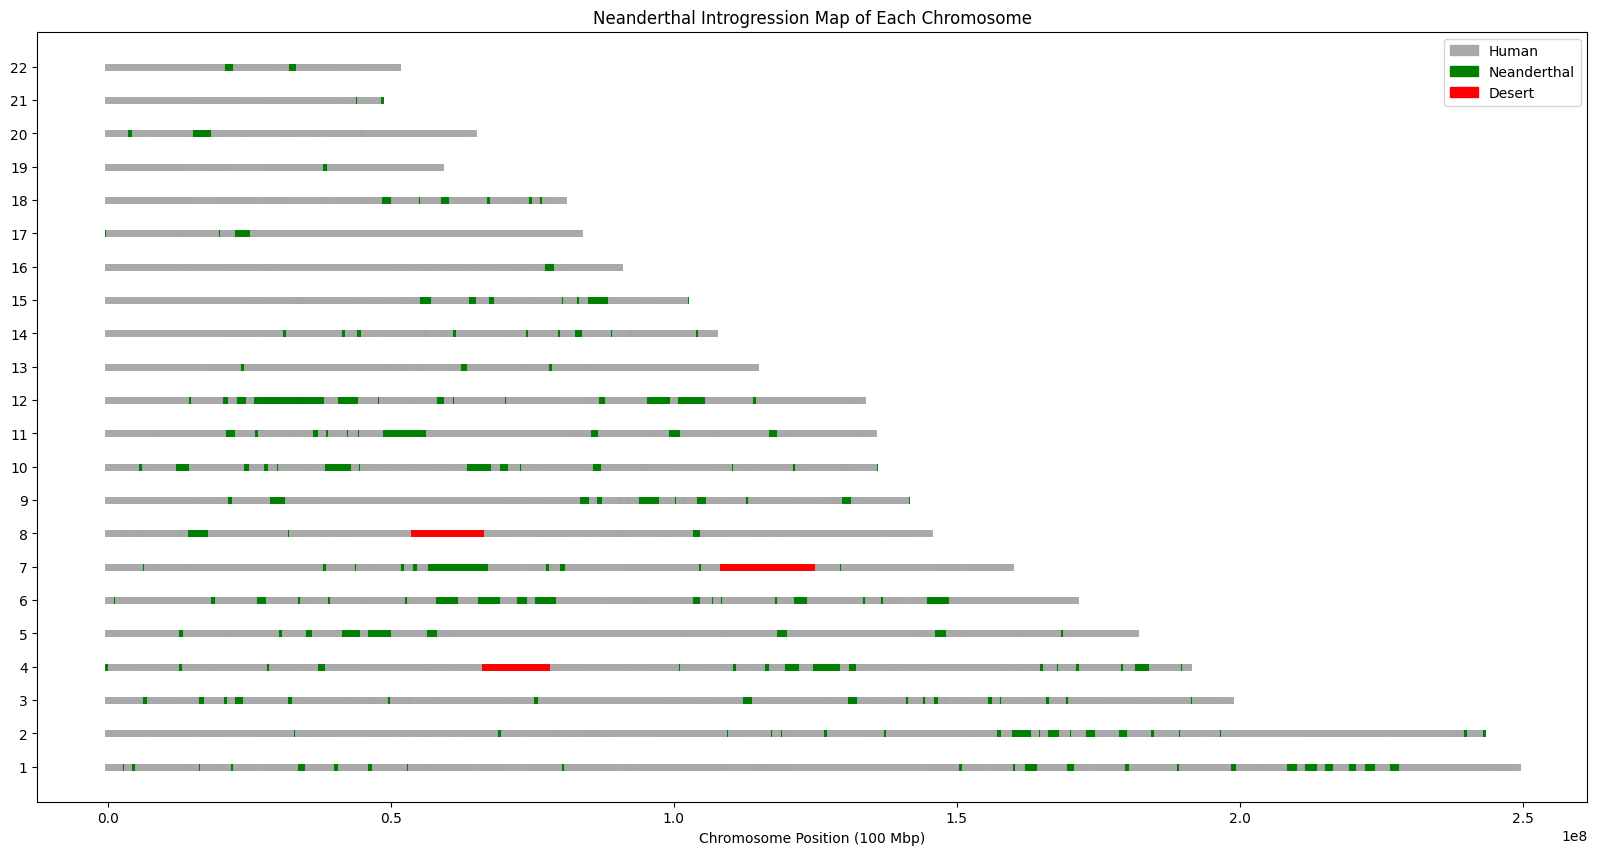

In [40]:
total_map = pd.DataFrame()

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for chr_idx in range(1, 23):
    chrmap = map_haplotypes(chr_idx)

    # accumulate in total_map using pd.concat
    total_map = pd.concat([total_map, chrmap], ignore_index=True)

    # plot this chromosome
    for start, stop, color in zip(chrmap["start"].values,
                                  chrmap["stop"].values,
                                  chrmap["color"].values):
        ax.plot([start, stop], [chr_idx, chr_idx], color=color, lw=5)

plt.title("Neanderthal Introgression Map of Each Chromosome")
ax.set_xlabel("Chromosome Position (100 Mbp)")
ax.set_yticks(range(1, 23))

red_patch = mpatches.Patch(color='red', label='Desert')
grey_patch = mpatches.Patch(color='darkgrey', label='Human')
green_patch = mpatches.Patch(color='green', label='Neanderthal')
plt.legend(handles=[grey_patch, green_patch, red_patch])

print(total_map)
plt.savefig("neanderthal_introgression_map.png", dpi=600)


## Infer deserts from probabilities (better efficiency)

In [ ]:
chr_lengths = {}

for line in open("hg19.genome-lengths", "r"):
  chr, length = line.split("\t")
  chr_lengths[chr] = int(length)
print(chr_lengths)

genome_gaps = pd.read_table("gap.txt", names=["chr", "start", "stop"], usecols=[1, 2, 3], dtype={"chr": str, "start": int, "stop": int})
genome_gaps["chr"] = genome_gaps["chr"].str.replace('chr', '_').str.split('_').str[1]
print(genome_gaps)

chrom_files = ["denisova/oceania/summaries/pred.{0}.thresh-50.length-0.00".format(x) for x in range(1, 23)]
print(chrom_files)

{'1': 249250621, '2': 243199373, '3': 198022430, '4': 191154276, '5': 180915260, '6': 171115067, '7': 159138663, '8': 146364022, '9': 141213431, '10': 135534747, '11': 135006516, '12': 133851895, '13': 115169878, '14': 107349540, '15': 102531392, '16': 90354753, '17': 81195210, '18': 78077248, '19': 59128983, '20': 63025520, '21': 48129895, '22': 51304566, 'X': 155270560, 'Y': 59373566}
    chr     start      stop
0     1         0     10000
1     1    177417    227417
2     1    267719    317719
3     1    471368    521368
4     1   2634220   2684220
..   ..       ...       ...
452   Y  22369679  22419679
453   Y  23901428  23951428
454   Y  28819361  58819361
455   Y  58917656  58967656
456   Y  59363566  59373566

[457 rows x 3 columns]
['denisova/oceania/summaries/pred.1.thresh-50.length-0.00', 'denisova/oceania/summaries/pred.2.thresh-50.length-0.00', 'denisova/oceania/summaries/pred.3.thresh-50.length-0.00', 'denisova/oceania/summaries/pred.4.thresh-50.length-0.00', 'denisova/oce

In [ ]:
def get_regions(chr, size):
  gap_ranges = []
  chrom_length = chr_lengths[str(chr)] # get chromosome length
  gaps = genome_gaps.loc[genome_gaps["chr"] == str(chr)] # get windows to avoid

  for gstart, gstop in zip(gaps["start"], gaps["stop"]):
    gap_ranges.append(range(gstart, gstop))

  return gap_ranges, itertools.filterfalse(lambda x: x in itertools.chain(*gap_ranges), range(0, chrom_length, size))

def get_ancestry(snp_file):

  # start = time.time()
  snp_frame = pd.read_table(snp_file, usecols=[1, 3, 10], names=["chr", "pos", "prob"], skiprows=27, dtype={"chr": str, "pos": int, "prob": float}) # import SNP probabilities from files
  # print(1, time.time() - start)

  chr = snp_frame.iloc[0]["chr"]

  print("Calculating ancestry for chromosome {0}".format(chr))

  chrom_length = chr_lengths[chr] # get chromosome length

  # winlist = []
  # frac_anc = []

  with open("denisova/oceania/summaries/ancestry_files/window_anc_{0}.txt".format(chr), "a") as file:
    for size in [100000, 1000000, 10000000]:
      for w_min in get_regions(int(chr), size)[1]:
        w_max = w_min + size

        # start = time.time()
        window_snps = snp_frame[snp_frame["pos"].between(w_min, w_max)]
        # print(3, time.time() - start)

        # start = time.time()
        snp_count = len(window_snps)
        # print(4, time.time() - start)

        # start = time.time()
        nean_prop = window_snps["prob"].sum()
        # print(5, time.time() - start)

        # start = time.time()
        # print("Window: {0}, {1}\t Total SNPs: {2}\t Neanderthal SNPs: {3}\t Neanderthal Fraction: {4:0.4f}".format(w_min, w_max, snp_count, nean_count, nean_count/snp_count))
        # winlist.append((w_min, w_max))
        # frac_anc.append(nean_count/snp_count)
        # print(6, time.time() - start)
        file.write("{0}\t{1}\t{2}\t{3}\t{4}\n".format(size, w_min, w_max, nean_prop, snp_count))

    # return winlist, frac_anc, chrom_length


In [ ]:
# for i in range(1, 23):
#   get_ancestry(chrom_files[i-1])

In [ ]:
def plot_ancestry(chr, size, ax):
  xdata = []
  ydata = []

  ancestry_file = "denisova/oceania/summaries/ancestry_files/window_anc_" + str(chr) + ".txt"

  with open(ancestry_file, "r") as file:
    for line in file:
      win_size, wmin, wmax, neanavg, snpc = line.split("\t")
      if int(win_size) == size:
        try:
          neanavg = float(neanavg.strip()) / int(snpc.strip())
        except(ZeroDivisionError):
          neanavg = 0
        wmid = (int(wmin) + int(wmax))/2
        xdata.append(wmid)
        ydata.append(neanavg)

  bad_regions = get_regions(chr, size)[0]
  for ran in bad_regions:
    bad_sites = [x for x in ran]
    ran_start = min(bad_sites)
    ran_stop = max(bad_sites)
    ran_mid = (ran_start + ran_stop)/2
    bisect.insort(xdata, ran_mid)
    ydata.insert(xdata.index(ran_mid), 0)
    ax.plot([ran_start, ran_stop], [0, 0], color="red", lw=3)

  # print(ydata)
  ax.plot(xdata, ydata)

  telocent = pd.read_table("telo_cent_hg19.txt", names=["chr", "start", "stop"], dtype={"chr": str, "start": int, "stop": int})
  chr_telocent = telocent.loc[telocent["chr"] == str(chr)]
  # print(chr_telocent)

  for tcstart, tcstop in zip(chr_telocent["start"], chr_telocent["stop"]):
    ax.plot([tcstart, tcstop], [0, 0], color="black", lw=4)

  box_style=dict(boxstyle='round', facecolor='lightgray', alpha=0.5)
  ax.text(0.025, 0.5, "Chr: " + str(chr), {'color':'black','weight':'heavy','size':20}, bbox=box_style, transform=ax.transAxes)

  ax.set_yticks([0, 0.1, 0.5])
  ax.set_ylim(-0.05, 0.3)


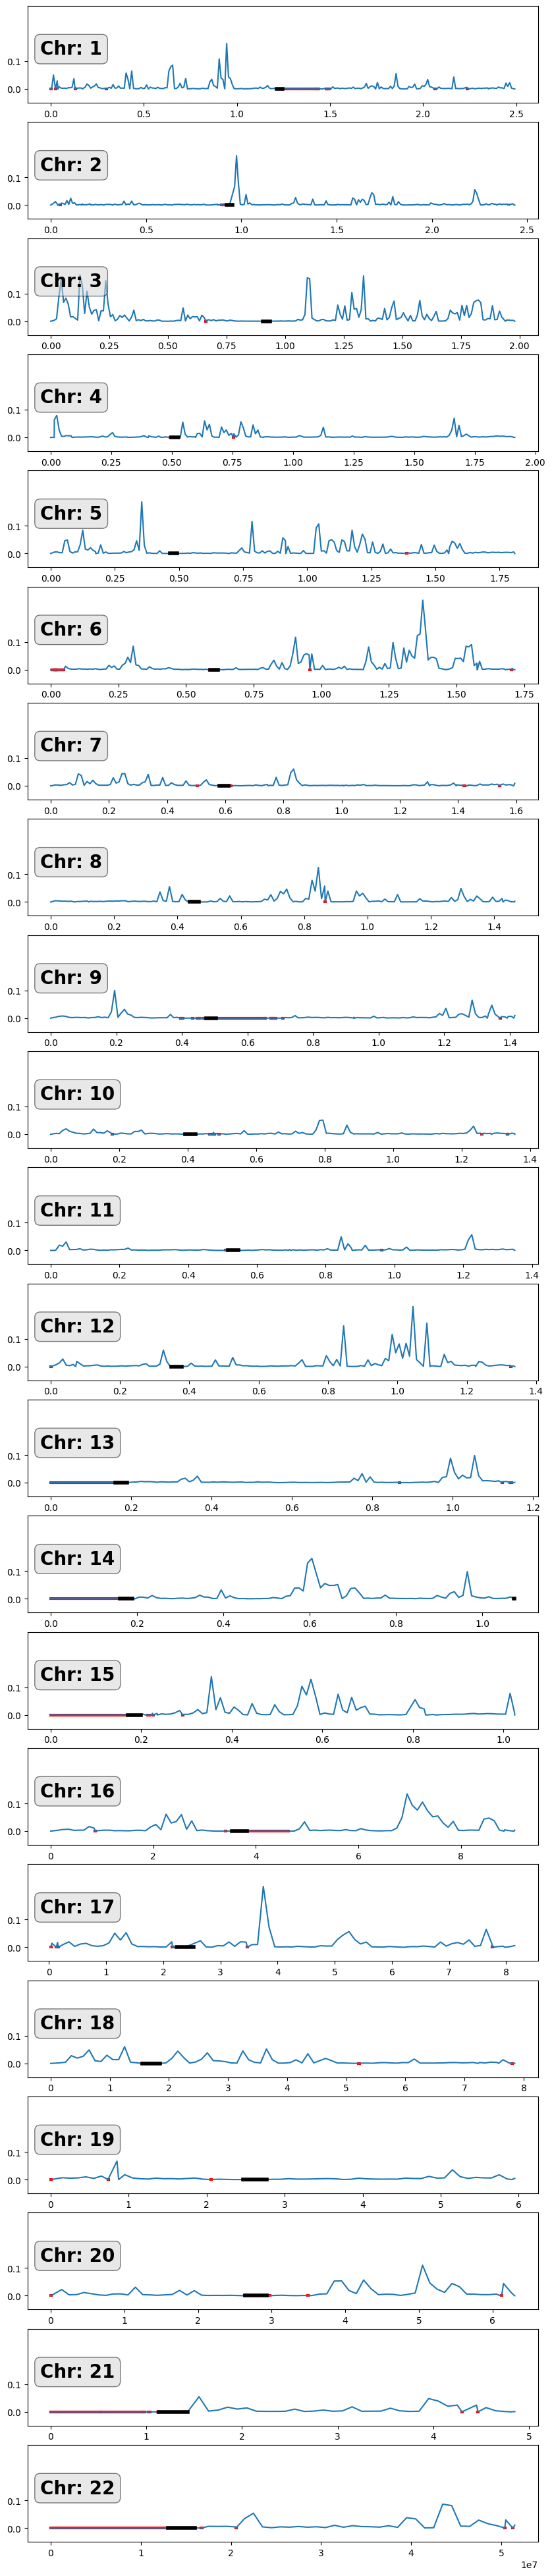

In [ ]:
fig, ax = plt.subplots(22, 1, figsize=(10,50))

for i in range(1, 23):
  plot_ancestry(i, 1000000, ax[i-1])

plt.savefig("chr_deni_ancestry_oceania_correct.png", dpi=600)

In [ ]:
def get_deserts(chr, size):
  ancestry_file = "denisova/oceania/summaries/ancestry_files/window_anc_" + str(chr) + ".txt"
  desert_file = "denisova/oceania/summaries/ancestry_files/window_deserts_" + str(chr) + ".txt"

  with open(ancestry_file, "r") as rfile:
    with open(desert_file, "w") as wfile:
      for line in rfile:
        win_size, wmin, wmax, fanc, snpc = line.split("\t")
        fanc = float(fanc.strip())
        wmid = (int(wmin) + int(wmax))/2
        if int(win_size) == size and int(snpc) >= 1000 and fanc < 0.01:
          wfile.write("{0}\t{1}\t{2}\t{3}\t{4}\n".format(size, wmin, wmax, fanc, snpc))

In [ ]:
for i in range(1, 23):
  get_deserts(i, 1000000)

## Analysis on Ancestry and B-statistic

In [ ]:
def find_correlation(chr, size):
  nean_file = "neandertal/eastasia/summaries/ancestry_files/window_anc_" + str(chr) + ".txt"
  deni_file = "denisova/oceania/summaries/ancestry_files/window_anc_" + str(chr) + ".txt"

  nean_frame = pd.read_table(nean_file, names=["size", "wmin", "wmax", "fracanc", "snpcount"], dtype={"size": int, "wmin": int, "wmax": int, "fracanc": float, "neancoutn": int, "snpcount": int}) # import SNP probabilities from files
  deni_frame = pd.read_table(deni_file, names=["size", "wmin", "wmax", "fracanc", "snpcount"], dtype={"size": int, "wmin": int, "wmax": int, "fracanc": float, "neancoutn": int, "snpcount": int}) # import SNP probabilities from files

  nean_frame = nean_frame.loc[nean_frame["size"] == size]
  deni_frame = deni_frame.loc[deni_frame["size"] == size]

  nean_frame["percentile"] = nean_frame["fracanc"].rank(pct=True)
  deni_frame["percentile"] = deni_frame["fracanc"].rank(pct=True)

  # nean_fracs = np.where(nean_frame["snpcount"] != 0, nean_frame["fracanc"]/nean_frame["snpcount"], 0)
  # deni_fracs = np.where(deni_frame["snpcount"] != 0, deni_frame["fracanc"]/deni_frame["snpcount"], 0)

  # change percentile to fracanc for chi2 test
  return nean_frame["percentile"].to_list(), deni_frame["percentile"].to_list()



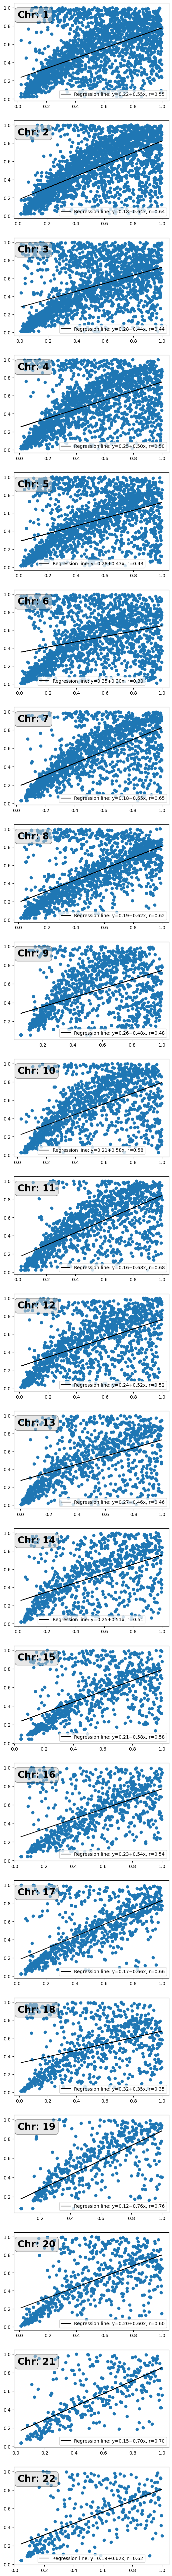

In [ ]:
fig, ax = plt.subplots(22, 1, figsize=(6,100))

for i in range(1, 23):

  nean_perc, deni_perc = find_correlation(i, 100000)
  slope, intercept, r, p, stderr = scipy.stats.linregress(nean_perc, deni_perc)
  line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
  ax[i-1].plot(nean_perc, intercept + slope * np.array(nean_perc), label=line, color="black")
  box_style=dict(boxstyle='round', facecolor='lightgray', alpha=0.5)
  ax[i-1].text(0.025, 0.85, "Chr: " + str(i), {'color':'black','weight':'heavy','size':20}, bbox=box_style, transform=ax[i-1].transAxes)
  ax[i-1].scatter(nean_perc, deni_perc)

  ax[i-1].legend()

plt.savefig("neanvsdeni_anc_correlation.png", dpi=600)


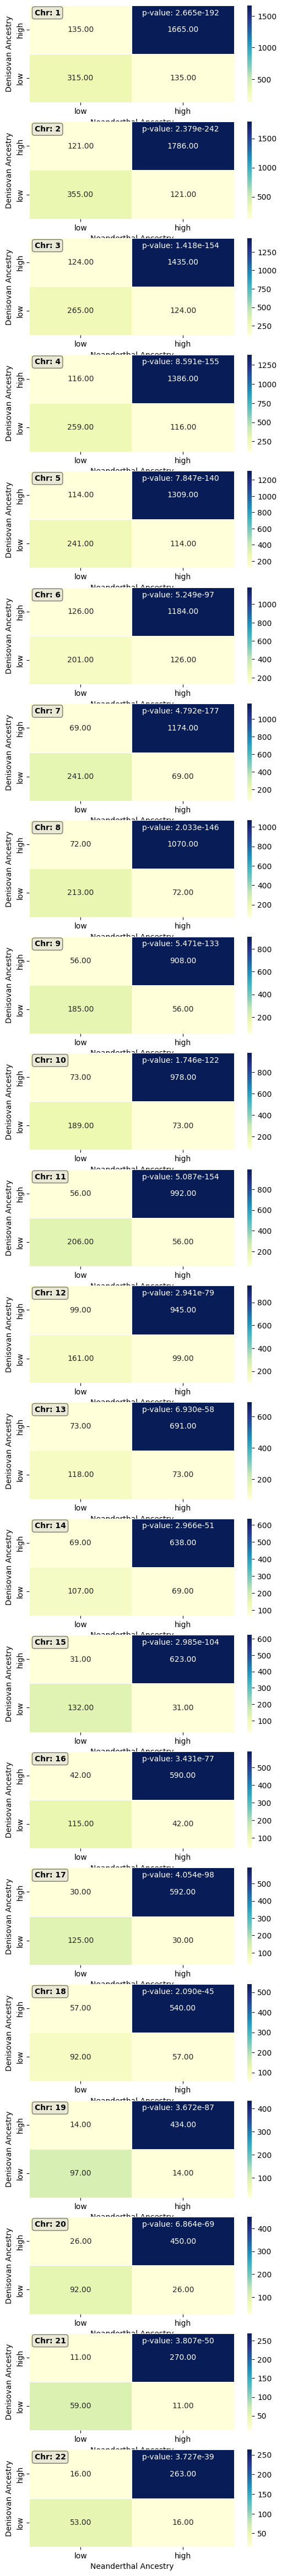

In [ ]:
fig, ax = plt.subplots(22, 1, figsize=(6,60))

for i in range(1, 23):

  nean_perc, deni_perc = find_correlation(i, 100000)
  nean_deni_20 = sum((k <= 0.2 and j <= 0.2) for k, j in zip(nean_perc, deni_perc))
  nean_20_deni_100 = sum((k <= 0.2 and j > 0.2) for k, j in zip(nean_perc, deni_perc))
  nean_100_deni_20 = sum((k > 0.2 and j <= 0.2) for k, j in zip(nean_perc, deni_perc))
  nean_deni_100 = sum((k > 0.2 and j > 0.2) for k, j in zip(nean_perc, deni_perc))

  anc_contingency = [[nean_20_deni_100, nean_deni_100], [nean_deni_20, nean_100_deni_20]]

  chi2, p, dof, expec = scipy.stats.chi2_contingency(anc_contingency)

  # print(anc_contingency)

  # print(chi2, p)

  ticklabels = ["low", "high"]

  line = f'p-value: {p:.3e}'

  res = sns.heatmap(anc_contingency, annot=True, fmt='.2f', cmap="YlGnBu", linewidths=.5, xticklabels=ticklabels, yticklabels=ticklabels[::-1], ax=ax[i-1])

  box_style=dict(boxstyle='round', facecolor='lightgray', alpha=0.5)
  ax[i-1].text(0.025, 0.9, "Chr: " + str(i), {'color':'black','weight':'heavy','size':10}, bbox=box_style, transform=ax[i-1].transAxes)
  ax[i-1].text(0.55, 0.9, line, {'color':'white','weight':'light','size':10}, transform=ax[i-1].transAxes)
  ax[i-1].set_xlabel("Neanderthal Ancestry")
  ax[i-1].set_ylabel("Denisovan Ancestry")

plt.savefig("neanvsdeni_anc_chisquare.png", dpi=300)

In [ ]:
def get_overlaps(set1, set2):
  num_overlaps = 0
  for i in range(len(set1)):
    start1 = set1.loc[i, "wmin"]
    stop1 = set1.loc[i, "wmax"]
    for j in range(len(set2)):
      start2 = set2.loc[j, "wmin"]
      stop2 = set2.loc[j, "wmax"]
      intersection = min(stop1,stop2) - max(start1,start2)

      if intersection > 0:
        num_overlaps += 1

  return num_overlaps

In [ ]:
def plot_overlaps(chr):
  nean_frame = pd.read_table("neandertal/eastasia/summaries/ancestry_files/window_anc_{0}.txt".format(str(chr)), names=["size", "wmin", "wmax", "fracanc", "snpcount"], dtype={"size": int, "wmin": int, "wmax": int, "fracanc": float, "neancoutn": int, "snpcount": int}) # import SNP probabilities from files
  deni_frame = pd.read_table("denisova/oceania/summaries/ancestry_files/window_anc_{0}.txt".format(str(chr)), names=["size", "wmin", "wmax", "fracanc", "snpcount"], dtype={"size": int, "wmin": int, "wmax": int, "fracanc": float, "neancoutn": int, "snpcount": int}) # import SNP probabilities from files
  nean_frame = nean_frame.loc[nean_frame["snpcount"] >= 1000].reset_index()
  deni_frame = deni_frame.loc[deni_frame["snpcount"] >= 1000].reset_index()

  nean_frame["perc"] = nean_frame["fracanc"].rank(pct=True)
  deni_frame["perc"] = deni_frame["fracanc"].rank(pct=True)


  nean_deserts = nean_frame.loc[nean_frame["perc"] < 0.1].reset_index()
  deni_deserts = deni_frame.loc[deni_frame["perc"] < 0.1].reset_index()

  print(len(nean_deserts), len(deni_deserts))

  actual_overlaps = get_overlaps(nean_deserts, deni_deserts)
  random_overlaps = []

  for j in range(0, 200):
    random_frame = nean_frame.sample(n=len(nean_deserts), ignore_index=True)
    random_overlaps.append(get_overlaps(deni_deserts, random_frame))

  ax[i-1].hist(random_overlaps)

  ax[i-1].set_xlim(50, 200)

  ax[i-1].axvline(x=actual_overlaps, color="red", label="denisovan desert overlap")

  ax[i-1].axvline(x=np.mean(random_overlaps), color="black", label="random region overlap")

  ax[i-1].legend()

  ax[i-1].set_xlabel("Number of Overlapping Regions")
  ax[i-1].set_ylabel("Frequency")
  ax[i-1].set_xlim(20, 300)

156 156
184 184
166 166
164 164
147 147
139 139
115 115
122 122
92 92
105 105
102 102
94 94
84 84
72 72
62 62
58 58
47 47
69 69
21 21
48 48
31 31
22 22


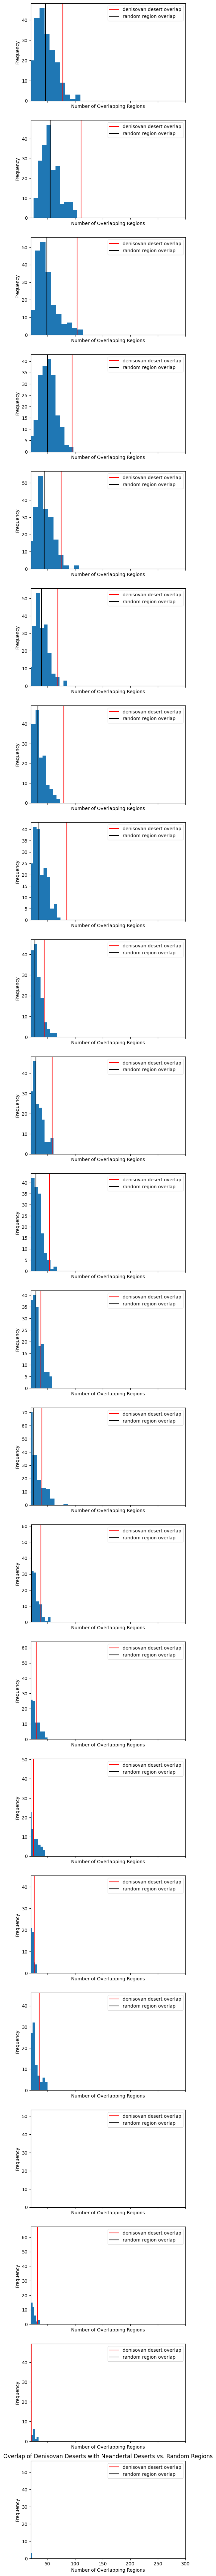

In [ ]:
fig, ax = plt.subplots(22, 1, figsize=(6, 100), sharex=True)

for i in range(1, 23):
  plot_overlaps(i)

plt.title("Overlap of Denisovan Deserts with Neandertal Deserts vs. Random Regions")

plt.savefig("deni_random_v_neandesert_.001.png", dpi=600)

In [ ]:
bstats = pd.read_table("bstats/bkgd_hg19.bed.gz", names=["chr", "start", "stop", "trash", "bstat"], usecols=["chr", "start", "stop", "bstat"], sep="\t", dtype={"chr": str, "start": int, "stop": int, "bstat": float})
bstats["chr"] = bstats["chr"].str[3:]
bstats.loc[bstats["chr"]=="X", "chr"] = 0 # replace chr X with 0 to avoid type casting errors
bstats["length"] = bstats.apply(lambda row: row["stop"] - row["start"], axis=1)
print(bstats)

        chr      start       stop  bstat  length
0         1     651930     741567  0.982   89637
1         1     741567     790028  0.976   48461
2         1     790028     820796  0.970   30768
3         1     820796     842130  0.964   21334
4         1     842130     856056  0.958   13926
...      ..        ...        ...    ...     ...
4376877   0  155159204  155190286  0.512   31082
4376878   0  155190286  155221572  0.519   31286
4376879   0  155221572  155238851  0.526   17279
4376880   0  155238851  155250813  0.533   11962
4376881   0  155250813  155260560  0.541    9747

[4376882 rows x 5 columns]


In [ ]:
# make sure chr is int once
bstats["chr"] = bstats["chr"].astype(int)


def window_stats(row, bstats_chr, rec_pos, rec_rate):
    wmin = row["wmin"]
    wmax = row["wmax"]

    # ---- avg_b: weighted bstat in window ----
    mask_b = (
        bstats_chr["start"].between(wmin, wmax)
        & bstats_chr["stop"].between(wmin, wmax)
    )
    window_b = bstats_chr.loc[mask_b]

    length_sum = window_b["length"].sum()
    if length_sum > 0:
        avgb = (window_b["bstat"] * window_b["length"]).sum() / length_sum
    else:
        avgb = np.nan

    # ---- avg_rec: mean recombination rate in window ----
    # rec_pos and rec_rate are numpy arrays
    left = np.searchsorted(rec_pos, wmin, side="left")
    right = np.searchsorted(rec_pos, wmax, side="right")

    if right > left:
        avg_rec = rec_rate[left:right].mean()
    else:
        avg_rec = np.nan

    return pd.Series({"avg_b": avgb, "avg_rec": avg_rec})


for chr_num in range(1, 23):
    print("chr: ", chr_num)

    bstats_chr = bstats.loc[bstats["chr"] == chr_num].copy()

    # load neanderthal windows
    nean_frame = pd.read_table(
        f"neandertal/eastasia/summaries/ancestry_files/window_anc_{chr_num}.txt",
        names=["size", "wmin", "wmax", "fracanc", "snpcount"],
        dtype={
            "size": int,
            "wmin": int,
            "wmax": int,
            "fracanc": float,
            "snpcount": int,
        },
    )
    rec_frame = pd.read_table(
        f"rec_rates/genetic_map_GRCh37_chr{chr_num}.txt",
        header=0,
        names=["chr", "pos", "rate", "map"],
        dtype={"chr": str, "pos": int, "rate": float, "map": float},
    )

    rec_frame["rate"] = rec_frame["rate"].interpolate()
    rec_pos = rec_frame["pos"].to_numpy()
    rec_rate = rec_frame["rate"].to_numpy()

    nean_frame[["avg_b", "avg_rec"]] = nean_frame.apply(
        window_stats,
        axis=1,
        result_type="expand",
        args=(bstats_chr, rec_pos, rec_rate),
    )

    nean_frame.to_csv(
        f"neandertal/eastasia/summaries/stats/window_stats_{chr_num}.txt",
        sep="\t",
        index=False,
    )

chr:  1
chr:  2
chr:  3
chr:  4
chr:  5
chr:  6
chr:  7
chr:  8
chr:  9
chr:  10
chr:  11
chr:  12
chr:  13
chr:  14
chr:  15
chr:  16
chr:  17
chr:  18
chr:  19
chr:  20
chr:  21
chr:  22


In [ ]:
df_list = []

for chr in range(1, 23):
  nean_frame = pd.read_table("neandertal/eastasia/summaries/ancestry_files/window_anc_{0}.txt".format(str(chr)), header=0, names=["size", "wmin", "wmax", "fracanc", "snpcount"], dtype={"size": int, "wmin": int, "wmax": int, "fracanc": float, "snpcount": int}) # import SNP probabilities from files
  nean_frame["chr"] = chr
  deni_frame = pd.read_table("denisova/oceania/summaries/ancestry_files/window_anc_{0}.txt".format(str(chr)), names=["size", "wmin", "wmax", "fracanc", "snpcount"], dtype={"size": int, "wmin": int, "wmax": int, "fracanc": float, "snpcount": int}) # import SNP probabilities from files
  stat_frame = pd.read_table("neandertal/eastasia/summaries/stats/window_stats_{0}.txt".format(str(chr)), header=0,names=["size", "wmin", "wmax", "fracanc", "snpcount","avg_b", "avg_rec"], dtype={"size": int, "wmin": int, "wmax": int, "fracanc": float, "snpcount": int, "avg_b": float, "avg_rec": float})

  # nean_frame = nean_frame.loc[nean_frame["size"] == 1000000]
  nean_frame["deni_anc"] = deni_frame.apply(lambda row: row["fracanc"] / row["snpcount"] if row["snpcount"] > 0 else 0, axis=1)
  nean_frame["avg_b"] = stat_frame["avg_b"]
  nean_frame["avg_rec"] = stat_frame["avg_rec"]
  df_list.append(nean_frame)

all_chroms = pd.concat(df_list)
all_chroms["anc"] = all_chroms.apply(lambda row: row["fracanc"] / row["snpcount"] if row["snpcount"] > 0 else 0, axis=1)


print(all_chroms)

         size      wmin      wmax    fracanc  snpcount  chr  deni_anc  \
0      100000    400000    500000     0.0000         0    1  0.000000   
1      100000    600000    700000     0.0000         0    1  0.000000   
2      100000    700000    800000     0.0000         0    1  0.000000   
3      100000    800000    900000     2.4239        81    1  0.000000   
4      100000    900000   1000000     7.6950       276    1  0.016594   
..        ...       ...       ...        ...       ...  ...       ...   
381   1000000  51000000  52000000    31.0752      1314   22  0.029236   
382  10000000  20000000  30000000  4981.3532     79456   22  0.010354   
383  10000000  30000000  40000000  1373.8028    101073   22  0.008878   
384  10000000  40000000  50000000  2987.3443    116862   22  0.008079   
385  10000000  50000000  60000000   543.6355     11124   22  0.027795   

        avg_b   avg_rec       anc  
0         NaN       NaN  0.000000  
1         NaN       NaN  0.000000  
2         NaN  

Text(0.5, 1.0, 'Ancestry Increases with B-statistic')

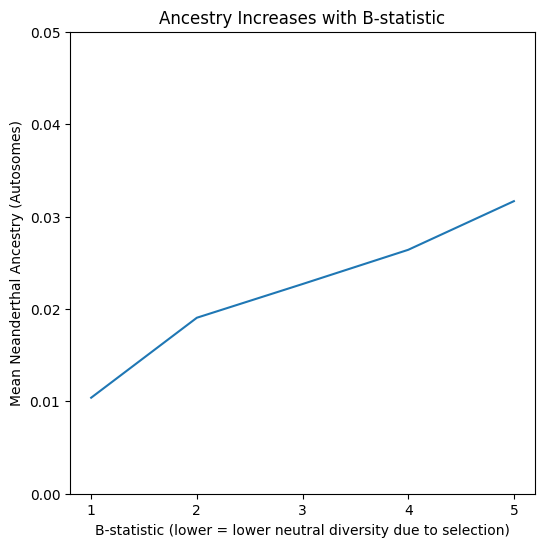

In [ ]:
all_chroms.dropna(inplace=True)

bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(all_chroms["avg_b"],
                all_chroms["anc"], statistic='mean', bins=5)

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True)

ax.plot(range(1, 6), bin_means)
ax.set_xticks(range(1, 6))
ax.set_yticks(np.linspace(0, 0.05, 6))
ax.set_xlabel("B-statistic (lower = lower neutral diversity due to selection)")
ax.set_ylabel("Mean Neanderthal Ancestry (Autosomes)")
ax.set_title("Ancestry Increases with B-statistic")

244


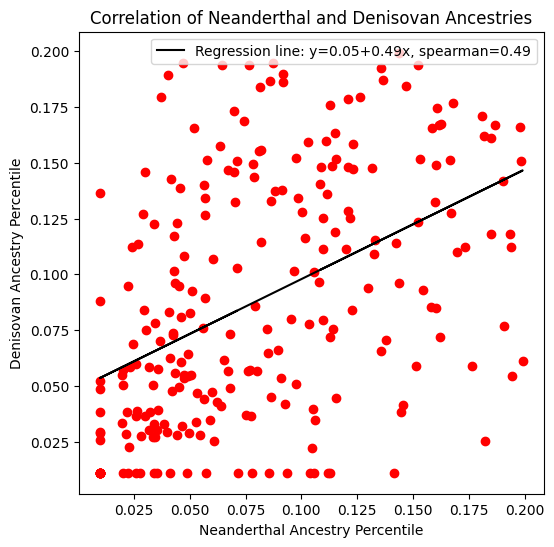

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

features = all_chroms.copy()
features["perc"] = features["anc"].rank(pct=True)
features["deni_perc"] = features["deni_anc"].rank(pct=True)
deserts = features.loc[(features["chr"] == 3) & (features["perc"] <= 0.2) & (features["deni_perc"] <= 0.2)]

nean20 = deserts["perc"].to_list()
deni20 = deserts["deni_perc"].to_list()
bstat = deserts["avg_b"].to_list()

# deni20 = np.log(deni20)
# nean20 = np.log(nean20)

print(len(nean20))

spr, pval = scipy.stats.spearmanr(nean20, deni20)
slope, intercept, r, p, stderr = scipy.stats.linregress(nean20, deni20)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, spearman={spr:.2f}'
ax.plot(nean20, intercept + slope * np.array(nean20), label=line, color="black")
box_style=dict(boxstyle='round', facecolor='lightgray', alpha=0.5)
ax.scatter(nean20, deni20, color="red")

ax.set_xlabel("Neanderthal Ancestry Percentile")
ax.set_ylabel("Denisovan Ancestry Percentile")
ax.set_title("Correlation of Neanderthal and Denisovan Ancestries")

ax.legend()

plt.savefig("neanvsdeni_anc_correlation_allchroms.png", dpi=600)

In [ ]:
from os import statvfs
from sklearn.linear_model import LinearRegression
import pingouin as pg

def plot_residuals():
  features = all_chroms.copy()
  features = features.loc[features["size"] == 10000000]
  features["nean_perc"] = features["anc"].rank(pct=True)
  features["deni_perc"] = features["deni_anc"].rank(pct=True)
  features["b_perc"] = features["avg_b"].rank(pct=True)
  features["r_perc"] = features["avg_rec"].rank(pct=True)

  features.dropna(inplace=True)
  stats = pg.partial_corr(data=features, x="nean_perc", y="deni_perc", covar="avg_b", method="spearman")
  print("partial correlation\n", stats)

  fig = plt.figure(figsize=(18, 12))
  ax1 = fig.add_subplot(331)
  ax4 = fig.add_subplot(334)
  ax2 = fig.add_subplot(332)
  ax5 = fig.add_subplot(335)
  ax6 = fig.add_subplot(336)
  ax3 = fig.add_subplot(333)
  ax7 = fig.add_subplot(414)

  # FIRST ROW PLOTS: neanderthal on B; denisovan on B; denisovan vs. neanderthal
  X = np.array(features["b_perc"].to_list()).reshape(-1, 1)
  y = np.array(features["nean_perc"].to_list()).reshape(-1, 1)
  model = LinearRegression()
  model.fit(X, y)
  y_pred = np.exp(model.predict(X))
  nresiduals = y_pred - y
  # print(str(model.intercept_[0]), model.coef_[0][0])
  line = f'Regression line: y={model.intercept_[0]:.2f}+{model.coef_[0][0]:.2f}x'

  ax1.scatter(X, y)
  ax1.plot(X, model.intercept_ + model.coef_ * X, label=line, color="black")
  ax1.legend()
  ax1.set_title("Regression of Neanderthal Ancestry on B-Statistic")

  X = np.array(features["b_perc"].to_list()).reshape(-1, 1)
  y = np.array(features["deni_perc"].to_list()).reshape(-1, 1)
  model = LinearRegression()
  model.fit(X, y)
  y_pred = np.exp(model.predict(X))
  dresiduals = y_pred - y

  ax3.scatter(X, y, color="tab:red")
  ax3.plot(X, model.intercept_ + model.coef_ * X, label=line, color="black")
  ax3.legend(loc="upper left")
  ax3.set_title("Regression of Denisovan Ancestry on B-Statistic")

  ax6.scatter(features["nean_perc"], features["deni_perc"], color="tab:purple")
  X = np.array(features["nean_perc"]).reshape(-1, 1)
  y = np.array(features["deni_perc"]).reshape(-1, 1)
  model = LinearRegression()
  model.fit(X, y)
  y_pred = np.exp(model.predict(X))
  bothresiduals = y_pred - y
  # print(str(model.intercept_[0]), model.coef_[0][0])
  line = f'Regression line: y={model.intercept_[0]:.2f}+{model.coef_[0][0]:.2f}x'
  ax6.plot(X, model.intercept_ + model.coef_ * X, label=line, color="black")
  ax6.legend()
  ax6.set_title("Denisovan vs. Neanderthal Ancestry")

  # SECOND ROW PLOTS: neanderthal on B residuals; denisovan on B residuals; denisovan vs. neanderthal residuals
  ax2.scatter(X, nresiduals, color="tab:green")
  ax2.set_title("Residuals Plotted Against B-Statistic")

  ax4.scatter(X, dresiduals, color="tab:red")
  ax4.set_title("Residuals Plotted Against B-Statistic")

  X = np.array(nresiduals).reshape(-1, 1)
  y = np.array(dresiduals).reshape(-1, 1)
  model = LinearRegression()
  model.fit(X, y)
  y_pred = np.exp(model.predict(X))
  rresiduals = y_pred - y
  # print(str(model.intercept_[0]), model.coef_[0][0])
  line = f'Regression line: y={model.intercept_[0]:.2f}+{model.coef_[0][0]:.2f}x'

  ax5.scatter(nresiduals, dresiduals, color="tab:purple")
  ax5.plot(X, model.intercept_ + model.coef_ * X, label=line, color="black")
  ax5.legend()
  ax5.set_title("Denisovan vs. Neanderthal Residuals")

  print("residual correlation\n", pg.corr(x=nresiduals.flatten(), y=dresiduals.flatten(), method="spearman"))

  # FOURTH ROW PLOTS
  perc_means, perc_edges, percbin = scipy.stats.binned_statistic(features["wmin"],
                  features["nean_perc"], statistic='mean', bins=20)

  b_means, b_edges, bbin = scipy.stats.binned_statistic(features["wmin"],
                  features["b_perc"], statistic='mean', bins=20)

  d_means, d_edges, dbin = scipy.stats.binned_statistic(features["wmin"],
                  features["deni_perc"], statistic='mean', bins=20)

  r_means, r_edges, rbin = scipy.stats.binned_statistic(features["wmin"],
                  features["r_perc"], statistic='mean', bins=20)

  ax7.plot(range(1, 21), perc_means, color="tab:green", label="Neanderthal")
  ax7.set_title("Neanderthal Ancestry Percentile vs. B-Statistic")
  ax7.plot(range(1, 21), d_means, color="tab:cyan", label="Denisovan")
  ax7.set_ylabel("Ancestry Percentile / B-Statistic")
  ax7.plot(range(1, 21), b_means, color="tab:orange", label="B-Statistic")
  axtwin = ax7.twinx()
  axtwin.plot(range(1, 21), r_means, color="tab:red", label="Recombination Rate")
  axtwin.set_ylabel("Recombination Rate")
  ax7.set_xticks(range(1, 21))
  ax7.legend(loc="upper right")
  axtwin.legend(loc="upper left")

  stats = pg.partial_corr(data=features, x="nean_perc", y="deni_perc", covar=["b_perc", "r_perc"], method="spearman")
  print("b and r covar\n", stats)

partial correlation
             n       r         CI95%     p-val
spearman  259  0.0842  [-0.04, 0.2]  0.177566
residual correlation
             n         r         CI95%     p-val     power
spearman  259  0.081454  [-0.04, 0.2]  0.191311  0.257802
b and r covar
             n         r          CI95%     p-val
spearman  259  0.061425  [-0.06, 0.18]  0.326667


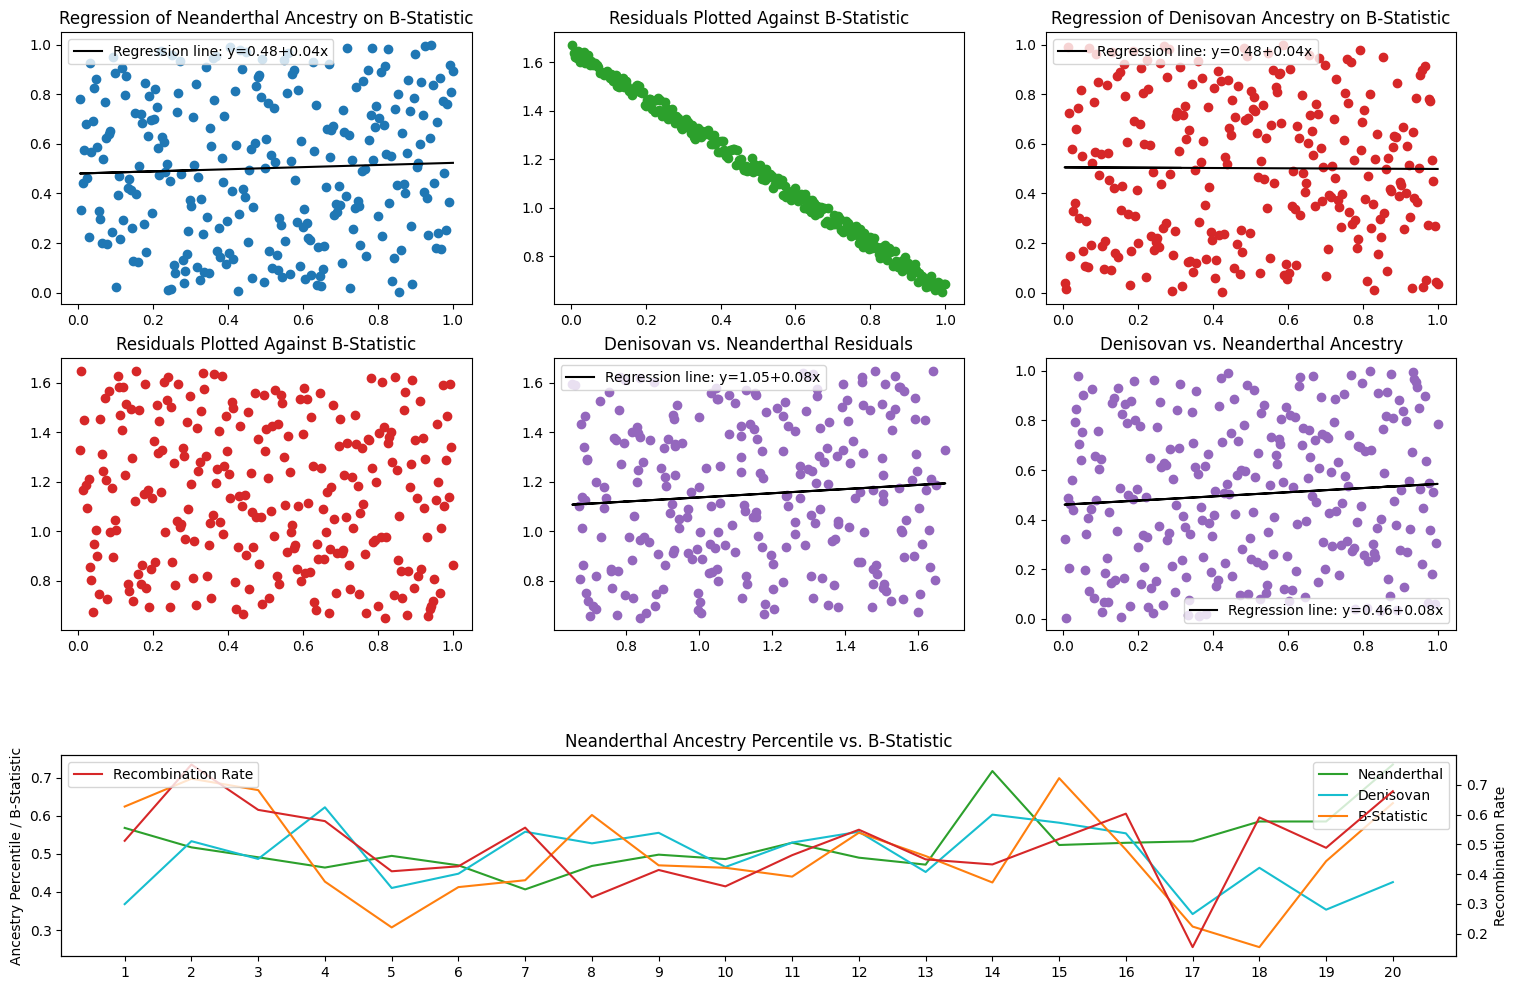

In [ ]:
plot_residuals()

## Not using but useful


## Infer deserts from probabilities

In [ ]:
chr_lengths = {}

for line in open("hg19.genome-lengths", "r"):
  chr, length = line.split("\t")
  chr_lengths[chr] = int(length)
print(chr_lengths)

genome_gaps = pd.read_table("telo_cent_hg19.txt", names=["chr", "start", "stop"], dtype={"chr": str, "start": int, "stop": int})
print(genome_gaps)

chrom_files = ["neandertal/eastasia/summaries/pred.{0}.thresh-50.length-0.00".format(x) for x in range(1, 23)]
print(chrom_files)

{'1': 249250621, '2': 243199373, '3': 198022430, '4': 191154276, '5': 180915260, '6': 171115067, '7': 159138663, '8': 146364022, '9': 141213431, '10': 135534747, '11': 135006516, '12': 133851895, '13': 115169878, '14': 107349540, '15': 102531392, '16': 90354753, '17': 81195210, '18': 78077248, '19': 59128983, '20': 63025520, '21': 48129895, '22': 51304566, 'X': 155270560, 'Y': 59373566}
   chr      start       stop
0    1          0      10000
1    1  121535434  124535434
2    1  249240621  249250621
3    2          0      10000
4    2  243189373  243199373
..  ..        ...        ...
65   X  155260560  155270560
66   X   58632012   61632012
67   Y          0      10000
68   Y   10104553   13104553
69   Y   59363566   59373566

[70 rows x 3 columns]
['neandertal/eastasia/summaries/pred.1.thresh-50.length-0.00', 'neandertal/eastasia/summaries/pred.2.thresh-50.length-0.00', 'neandertal/eastasia/summaries/pred.3.thresh-50.length-0.00', 'neandertal/eastasia/summaries/pred.4.thresh-50.leng

In [ ]:
def get_ancestry(snp_file, window_size):
    snp_frame = pd.read_table(
        snp_file,
        usecols=[1, 3, 10],
        names=["chr", "pos", "prob"],
        skiprows=27,
        dtype={"chr": str, "pos": int, "prob": float}
    )  # import SNP probabilities from files

    chr = snp_frame.loc[0, "chr"]

    chrom_length = chr_lengths[chr]  # get chromosome length

    gaps = genome_gaps.loc[genome_gaps["chr"] == chr]  # get windows to avoid

    winlist = []
    frac_anc = []

    for w_min in range(0, chrom_length, window_size):
        w_max = w_min + window_size

        in_gap = False
        for gstart, gstop in zip(gaps["start"], gaps["stop"]):
            if ((w_min >= gstart and w_min <= gstop) or
                (w_max >= gstart and w_max <= gstop) or
                (w_min <= gstart and w_max >= gstop)):
                in_gap = True
                break

        if in_gap:
            winlist.append((w_min + w_max) / 2)
            frac_anc.append(0)
            continue

        window_snps = snp_frame.loc[
            (snp_frame["pos"] >= w_min) & (snp_frame["pos"] < w_max)
        ]
        nean_snps = window_snps.loc[window_snps["prob"] >= 0.25]
        snp_count = len(window_snps)
        nean_count = len(nean_snps)

        if snp_count >= 10:
            winlist.append((w_min + w_max) / 2)
            frac_anc.append(nean_count / snp_count)

    return winlist, frac_anc, chrom_length

In [ ]:
def plot_ancestry(chr, size, ax):
  windows, fracs, chrom_len = get_ancestry(chrom_files[chr-1], size)

  ax.plot(windows, fracs, label=str(size))

  gaps = genome_gaps.loc[genome_gaps["chr"] == str(chr)] # get windows to avoid
  for start, stop in zip(gaps["start"], gaps["stop"]):
    # print(start, stop)
    ax.plot([start, stop], [0, 0], lw=10, color="black")

  ax.set_xlim(-1000000, chrom_len+1000000)
  ax.set_ylim(-0.5, 0.5)
  ax.legend()

  return fracs

/usr/local/lib/python3.12/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


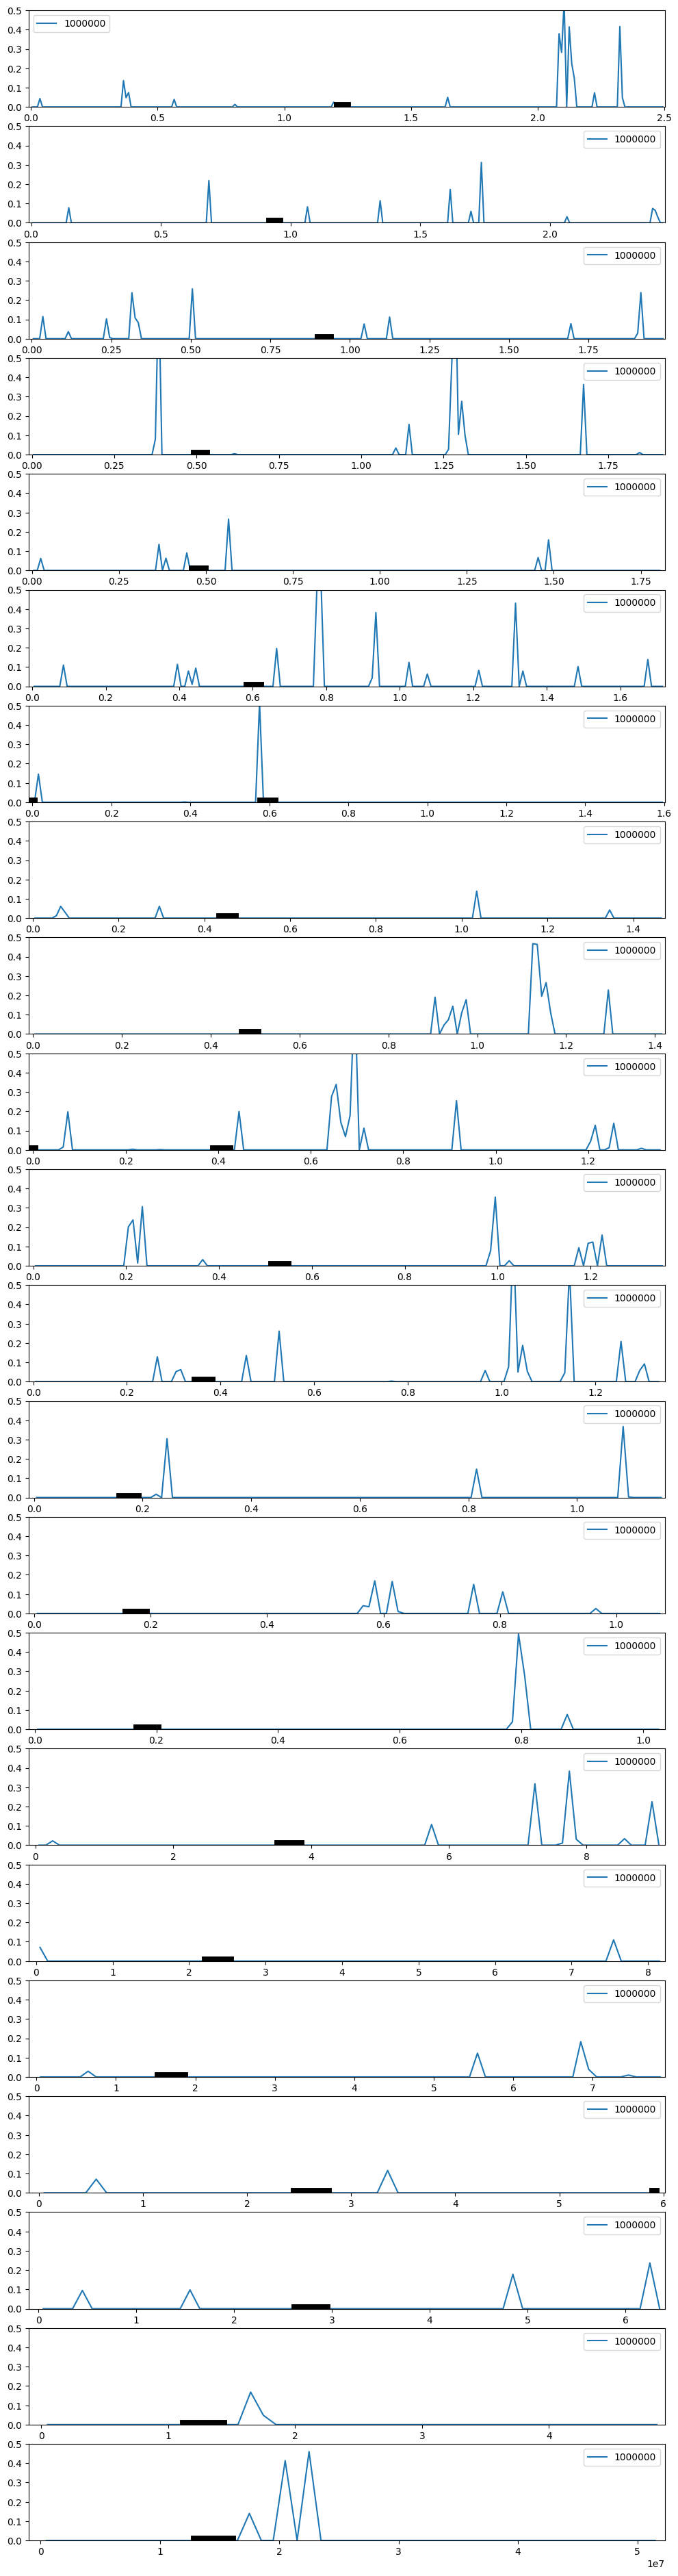

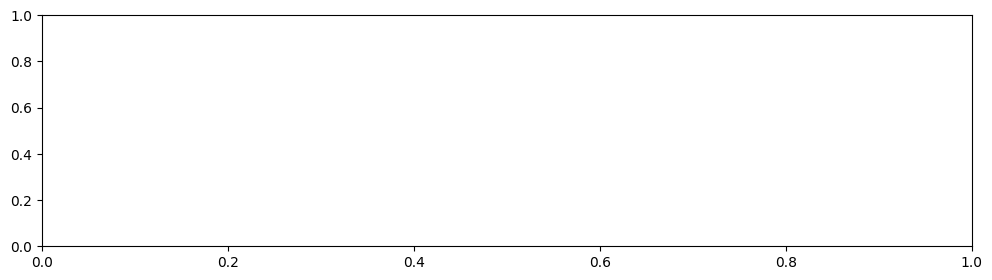

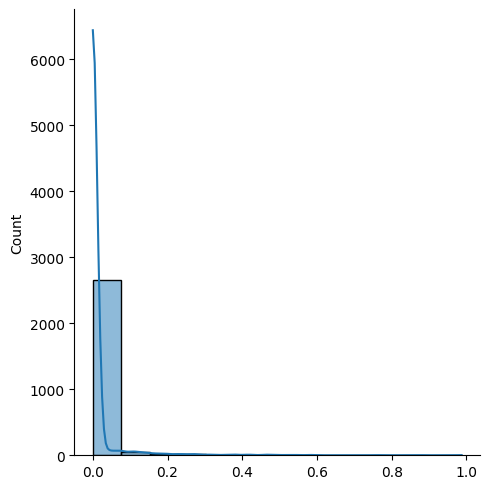

In [ ]:
fig, ax = plt.subplots(22, 1, figsize=(12, 48))
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 3))

for window in [1000000]:
  all_fracs = []
  for i in range(1, 23):
    all_fracs = all_fracs + plot_ancestry(i, window, ax[i-1])

  sns.displot(all_fracs, kde=True, ax=ax2)

2608
0.11356925141075278
2608
-0.0489660780139953


/tmp/ipython-input-457994779.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.dropna(inplace=True)
/tmp/ipython-input-457994779.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.dropna(inplace=True)


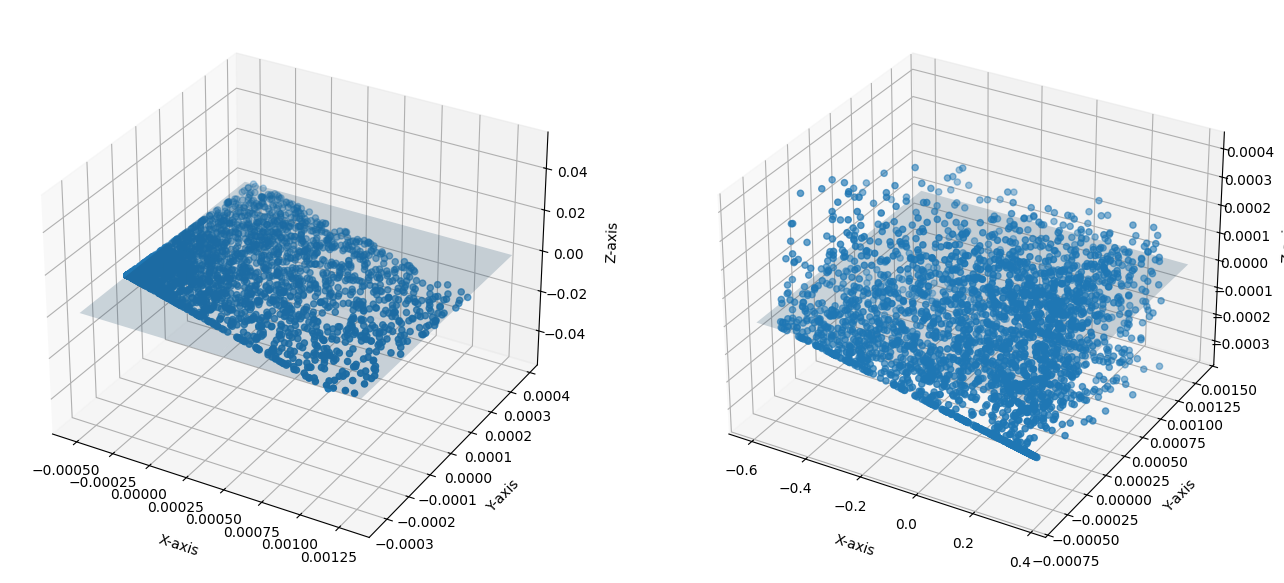

In [ ]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1, projection='3d')

# Create a PCA instance: model
model = PCA()

# Features from dataframe
features = all_chroms.copy()
features["perc"] = features["anc"].rank(pct=True)
features["deni_perc"] = features["deni_anc"].rank(pct=True)
deserts = features.loc[(features["perc"] <= 0.2) & (features["deni_perc"] <= 0.2)]
subset = deserts[["anc", "deni_anc"]]

print(len(subset))
subset.dropna(inplace=True)
# print(features.to_string())

# Normalize features
normed_features = subset - subset.mean()

# Apply the fit_transform method of model to grains: pca_features
pca_features = model.fit_transform(normed_features)

# Assign 0th column of pca_features: xs
xs = pca_features[:, 0]

# Assign 1st column of pca_features: ys
ys = pca_features[:, 1]

# zs = pca_features[:, 2]

# Scatter plot xs vs ys
ax.scatter(xs, ys)
yy, xx = np.meshgrid(np.linspace(min(ys), max(ys), 3), np.linspace(min(xs), max(xs), 3))
zz = yy*0
ax.plot_surface(xx, yy, zz, alpha=0.2)

ax.set_xlabel("X-axis", labelpad=10)
ax.set_ylabel("Y-axis", labelpad=10)
ax.set_zlabel("Z-axis", labelpad=10)

# Calculate the Pearson correlation of xs and ys
spr, pval = scipy.stats.spearmanr(xs, ys)

# Display the correlation
print(spr)

# WITH B STAT FEATURE / 3RD AXIS
ax = fig.add_subplot(1, 2, 2, projection='3d')

subset = deserts[["anc", "deni_anc", "avg_b"]]

print(len(subset))
subset.dropna(inplace=True)
# print(features.to_string())

# Normalize features
normed_features = subset - subset.mean()

# Apply the fit_transform method of model to grains: pca_features
pca_features = model.fit_transform(normed_features)

# Assign 0th column of pca_features: xs
xs = pca_features[:, 0]

# Assign 1st column of pca_features: ys
ys = pca_features[:, 1]

zs = pca_features[:, 2]

# Scatter plot xs vs ys
yy, xx = np.meshgrid(np.linspace(min(ys), max(ys), 3), np.linspace(min(xs), max(xs), 3))
zz = yy*0
ax.plot_surface(xx, yy, zz, alpha=0.2)

ax.scatter(xs, ys, zs)
ax.set_xlabel("X-axis", labelpad=10)
ax.set_ylabel("Y-axis", labelpad=10)
ax.set_zlabel("Z-axis", labelpad=10)

# Calculate the Pearson correlation of xs and ys
spr, pval = scipy.stats.spearmanr(xs, ys)

# Display the correlation
print(spr)

plt.show()

R^2 0.19600101916769463


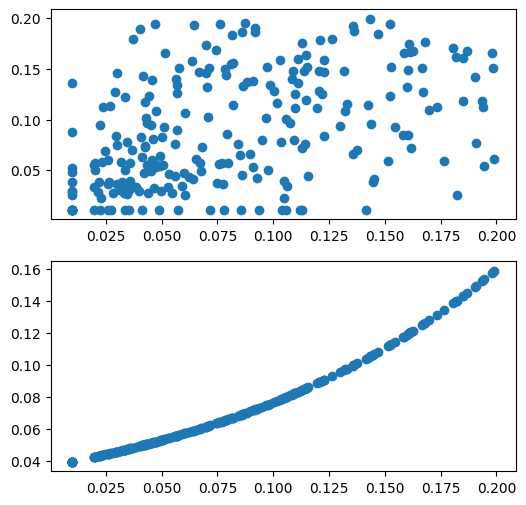

In [ ]:
from sklearn.linear_model import LinearRegression

X = np.array(nean20).reshape(-1, 1)
y = np.array(np.log(deni20)).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
y_pred = np.exp(model.predict(X))
print('R^2', model.score(X, y))

fig, ax = plt.subplots(2, 1, figsize=(6,6))
ax[0].scatter(X, np.exp(y))
ax[1].scatter(X, y_pred)